In [11]:
library(readr)
library(forecast)
library(zoo)
tb24 <- read_csv("24_cont_anom.csv")

Parsed with column specification:
cols(
  timestamp = col_date(format = ""),
  coverage = col_double(),
  dayofyear = col_integer(),
  mean = col_double(),
  std = col_double(),
  counts = col_integer(),
  z = col_double(),
  perc_diff = col_double(),
  anom = col_double()
)


ERROR: Error in is.data.frame(x): object 'mydata' not found


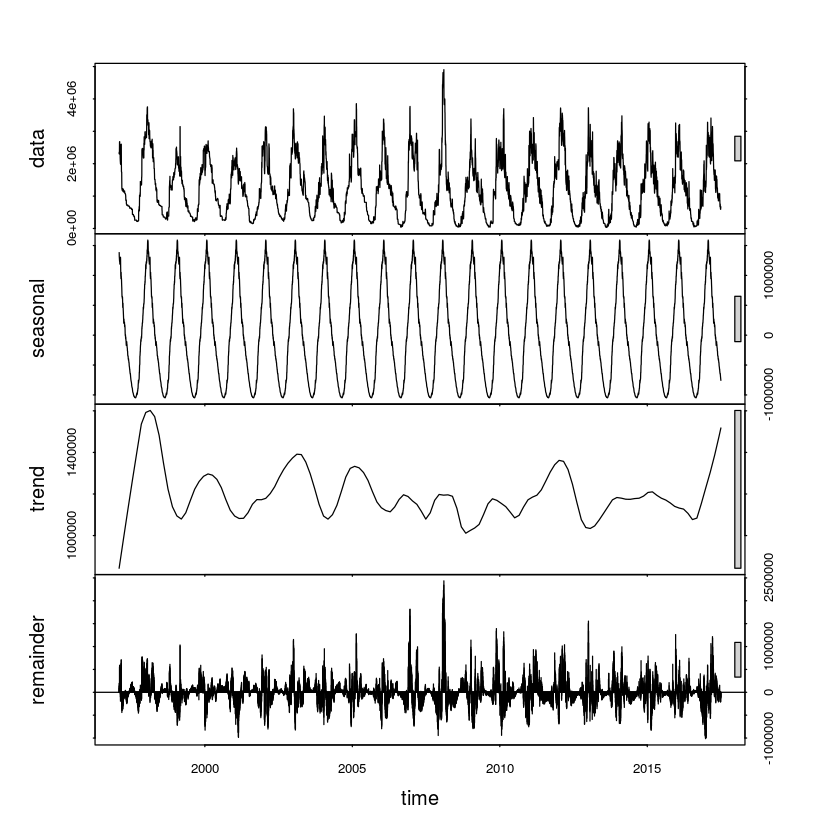

In [12]:
##deseasonalizing
## Create a daily Date object - helps my work on dates
inds <- seq(as.Date("1997-02-04"), as.Date("2017-06-26"), by = "day")
## Create a time series object
myts <- ts(tb24$coverage,
           start = c(1997, as.numeric(format(inds[1], "%j"))),
           frequency = 365)
myts = na.locf(myts)
#decompose the model
decomp = stl(myts, s.window="periodic") # breaks series into seasons
destpts <- seasadj(decomp) # attempts to remove seasonal trend
plot(decomp)

write.table(mydata, "deseasonalized.csv", sep=",") 

In [17]:
decomp.df = as.data.frame(decomp$time.series)
decomp.df$timestamp = inds
write.csv(decomp.df, "24km_stl.csv", row.names=FALSE)
#write.table(decomp.df, "24km_stl.csv", sep=",")

Warning message in plot.xy(xy, type, ...):
“plot type 'partial' will be truncated to first character”

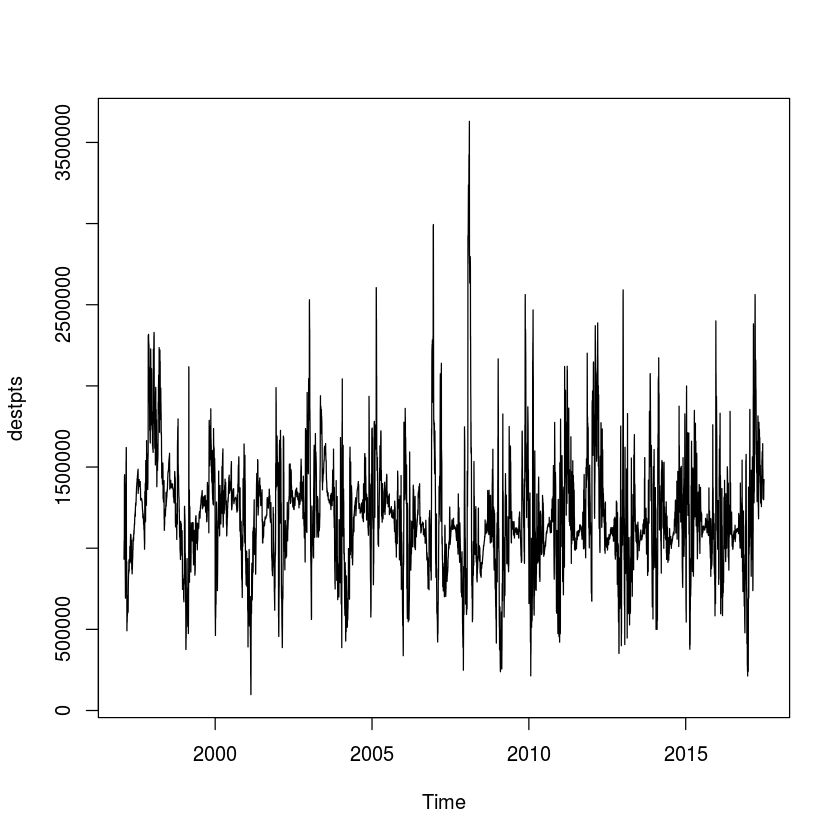

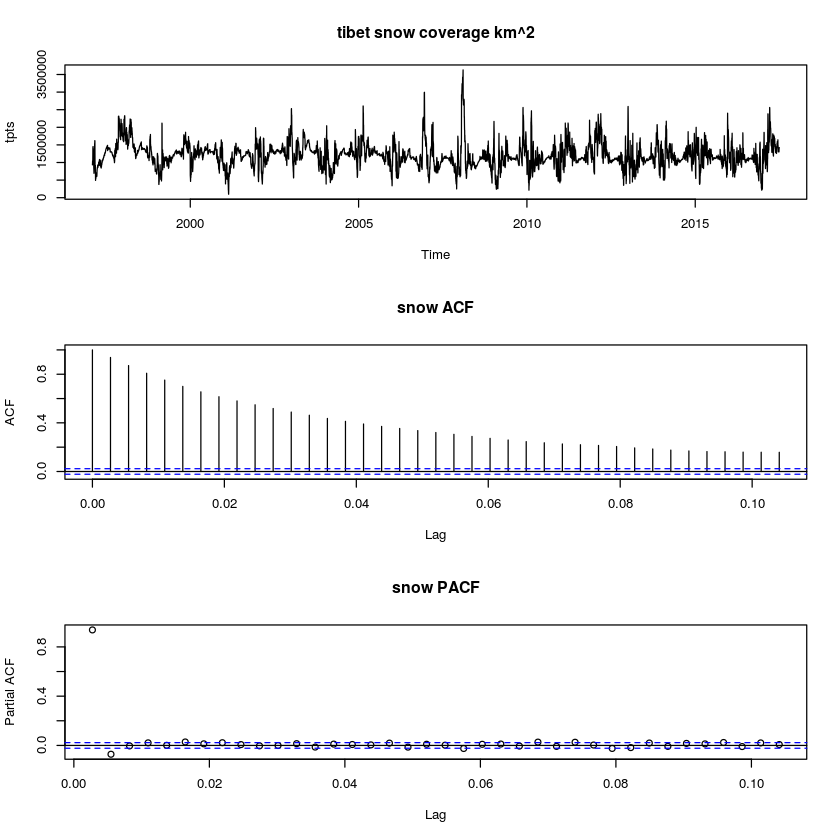

In [3]:
plot(destpts)
#either use the climate averaged anomalies or the deseasonalized trend
tpts = destpts
#first look at the plots
par(mfrow=c(3,1))
plot(tpts, main="tibet snow coverage km^2")
acf(tpts, main= "snow ACF")
pacf(tpts, type="partial", main="snow PACF")

Warning message in plot.xy(xy, type, ...):
“plot type 'partial' will be truncated to first character”


Call:
arima(x = ts.log, order = c(6, 0, 0))

Coefficients:
         ar1      ar2      ar3     ar4      ar5     ar6  intercept
      1.0099  -0.0814  -0.0395  0.0460  -0.0234  0.0214    13.9548
s.e.  0.0116   0.0165   0.0165  0.0165   0.0165  0.0116     0.0186

sigma^2 estimated as 0.01159:  log likelihood = 6031.06,  aic = -12046.12


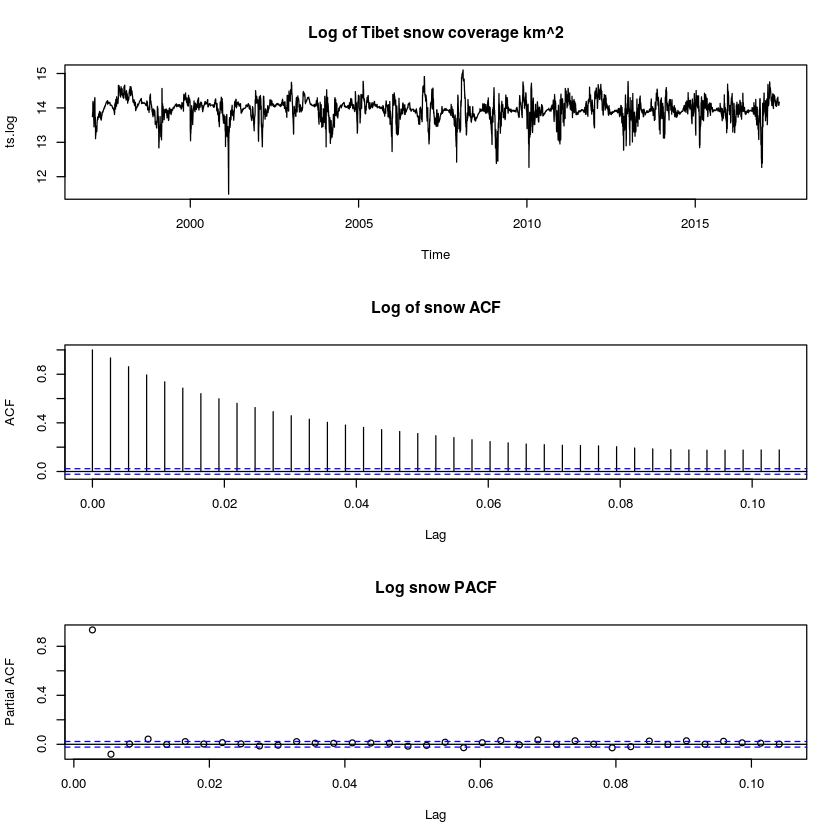

In [18]:
#try to make ts have no nan values
tptsPos = tpts

#log drops acf off. looks like an AR(5)
ts.log = log(tptsPos)
par(mfrow=c(3,1))
plot(ts.log, main="Log of Tibet snow coverage km^2")
acf(ts.log, main= "Log of snow ACF")
pacf(ts.log, type="partial", main="Log snow PACF")


#lowest aic so far...
fitDes <- arima(ts.log, order=c(6,0,0))
print(fitDes)

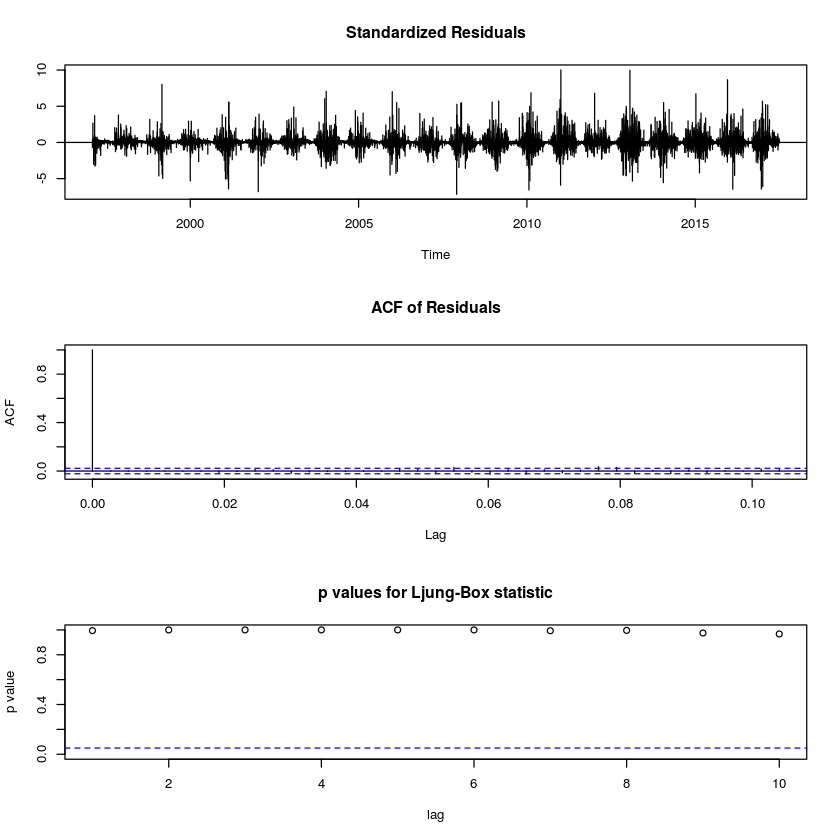

In [19]:
tsdiag(fitDes)
myResDes <- residuals(fitDes)

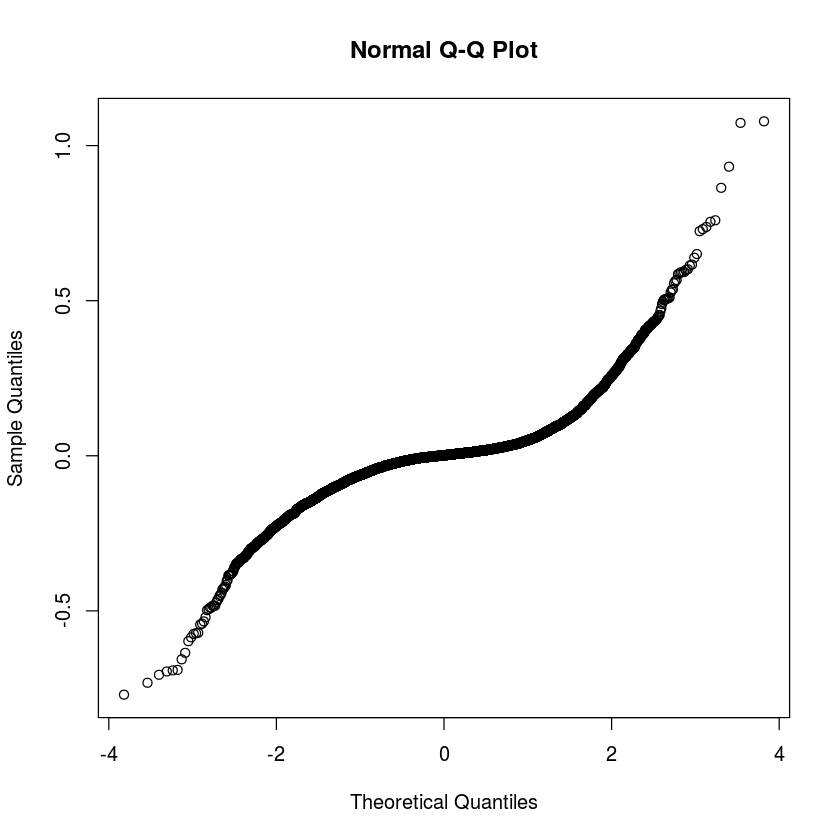

In [7]:
par(mfrow=c(1,1))
qqnorm(myResDes, main = "Normal Q-Q Plot", xlab = "Theoretical Quantiles", ylab = "Sample Quantiles")

Flat middle with a downward sloping left and an upward sloping right indicates a heavy tailed distribution. 

In [ ]:
#autofit doesn't quite work as well as manually searching
autotpts = auto.arima(ts.log, seasonal=TRUE)
print(autotpts)
tsdiag(autotpts)
myResAutotpts <- residuals(autotpts)
autoDetpts = auto.arima(destpts, seasonal=FALSE)
print(autoDetpts)
tsdiag(autoDetpts)
myResautoDetpts <- residuals(autoDetpts)


par(mfrow=c(1,1))
qqnorm(myResDes, main = "Normal Q-Q Plot", xlab = "Theoretical Quantiles", ylab = "Sample Quantiles")

library(tsDyn)
autopairs(ts.log, lag=1, type="regression")
hist(ts.log, br = 15) #does not suggest bimodality
fitCmp <- arima(ts.log, order=c(5,0,0))


selectSETAR(ts.log, m=5, mL=1:6, mH=1:6, thSteps = 1:5, thDelay=0:2)

mod = list()
mod[['linear']] <- linear(ts.log, m=6)
mod[['setar']] <- setar(ts.log, m=6, mL=1, mH=1, thDelay=1)
mod[['lstar']] <- lstar(ts.log, m=6, thDelay=2)
mod[["aar"]] <- aar(ts.log, m=6)

#tbd neural network
mod[["nnetTs"]] <- nnetTs(ts.log, m=5, d=t, steps=10, size=5)
sapply(mod, AIC)

sapply(mod, MAPE)

summary(mod[['linear']])
plot(mod[["linear"]])

summary(mod[['lstar']])
plot(mod[["lstar"]])